# 09wk-2: (생성모형) – Generative Adversarial Network (GAN)

최규빈  
2025-05-05

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/09wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-zVPiasR6XsxI1sn94-Tmqq&si=uVhkHcuS7nIAnNb_>

# 2. Imports

In [3]:
import torch 
import torchvision
import matplotlib.pyplot as plt 

# 3. GAN (Goodfellow et al. 2014) intro

## A. 잡썰

`-` 저자: 이안굿펠로우

-   천재임
-   지도교수가 요수아 벤지오

`-` 저는 아래의 논문 읽고 소름돋았어요..

-   https://arxiv.org/abs/1406.2661

`-` 최근 10년간 머신러닝 분야에서 가장 혁신적인 아이디어이다. (얀르쿤,
2014년 시점..)

`-` 야사와 만화로 배우는 인공지능

-   https://wedatalab.tistory.com/125

## B. GAN의 원리

`-` GAN의 원리는 경찰과 위조지폐범이 서로 선의의(?) 경쟁을 통하여 서로
발전하는 모형으로 설명할 수 있다.

> The generative model can be thought of as analogous to a team of
> fakers, trying to produce fake currency and use it without detection,
> while the discriminative model is analogous to the police, trying to
> detect the counterfeit currency. Competition in this game drives both
> teams to improve their methods until the counterfeits are
> indistiguishable from the genuine articles.

`-` 서로 적대적인(adversarial) 네트워크(network)를 동시에 학습시켜
가짜이미지를 만든다(generate)

`-` 무식한 상황극..

-   위조범: 가짜돈을 만들어서 부자가 되어야지! (가짜돈을 그림)
-   경찰: (위조범이 만든 돈을 보고) 이건 가짜다!
-   위조범: 걸렸군.. 더 정교하게 만들어야지..
-   경찰: (깜빡 속으며) 이건 진짠가?… –\> 상사에게 혼남 –\> 판별능력
    업그레이드 –\> 이건 가짜다!!
-   위조범: 더 정교하게 만들자..
-   경찰: 더 판별능력을 업그레이드 하자!
-   반복..

`-` 굉장히 우수한 경찰조차도 진짜와 가짜를 구분하지 못할때(=진짜
이미지를 0.5의 확률로만 진짜라고 말할때 = 가짜 이미지를 0.5의 확률로만
가짜라고 말할때) 학습을 멈춘다.

## C. 생성모형이란? (쉬운 설명)

`-` 사진속에 들어있는 동물이 개인지 고양이인지 맞출수 있는 기계와 개와
고양이를 그릴수 있는 기계중 어떤것이 더 시각적보에 대한 이해가 깊다고 볼
수 있는가?

`-` 진정으로 인공지능이 이미지자료를 이해했다면, 이미지를 만들수도
있어야 한다. $\to$ 이미지를 생성하는 모형을 만들어보자 $\to$ 성공

![](https://upload.wikimedia.org/wikipedia/commons/1/1f/Woman_1.jpg)

`-` 뭘 분류하려는 목적을 가진게 판별모형이면 뭘 만들려는 목적을 가진게
생성모형이고 생성모형이 더 우수하다.

> 명언: 만들수 없다면 이해하지 못한 것이다, 리처드 파인만 (천재
> 물리학자)

## D. 생성모형이란? 통계학과 버전의 설명

`-` 이미지 $\boldsymbol{X}$ 가 주어졌을 경우 라벨을 $y$ 라고 하자.

`-` 이미지를 보고 라벨을 맞추는 일은 $p(y| \boldsymbol{X})$에 관심이
있다고 볼 수 있다. – 판별모형

`-` 이미지를 생성하는 일은 $p(\boldsymbol{X},y)$에 관심이 있는것이다. –
생성모형

`-` 데이터의 생성확률 $p(\boldsymbol{X},y)$을 알면 클래스의 사후확률
$p(y|\boldsymbol{X})$를 알 수 있음. (아래의 수식 참고) 하지만 역은
불가능

$$p(y|{\boldsymbol X}) = \frac{p({\boldsymbol X},y)}{p({\boldsymbol X})} = \frac{p({\boldsymbol X},y)}{\sum_{y}p({\boldsymbol X},y)}$$

-   즉 이미지를 생성하는일은 분류문제보다 더 어려운 일이라 해석가능

## E. 철학의 차이

> 명언: 제한된 정보만으로 어떤 문제를 풀 때, 그 과정에서 원래의 문제보다
> 일반적인 문제를 풀지 말고 (=문제를 괜히 어렵게 만들어서 풀지 말고),
> 가능한 원래의 문제를 직접 풀어야한다. 배프닉 (SVM 창시자)

`-` 따라서 배프닉의 원리에 의하면 일반적인 분류문제를 해결할때
“판별모형이 생성모형보다 더 바람직한 접근법”이라 할 수 있음. 즉 개와
고양이를 구분할 때, 그려진 개와 고양이 사진을 잘 구분하면 되는 것이지
굳이 개와 고양이를 그릴줄 알아야하는건 아니라는 의미.

`*` 예전에는 머신러닝의 응용분야가 “분류/회귀”에 한정된 느낌이었는데
요즘은 생성모형도 인기있음.

-   마인드가 되게 달라요

# 4. GAN의 구현

## A. Data

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
to_tensor = torchvision.transforms.ToTensor()
X_real = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==3])

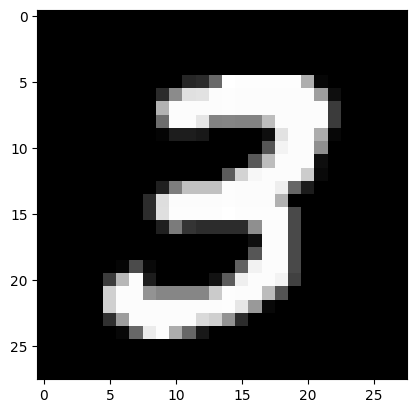

In [5]:
plt.imshow(X_real[0].squeeze(),cmap="gray")

## B. 페이커 생성

> “net_faker: noise $\to$ 가짜이미지” 를 만들자.

`-` 네트워크의 입력: (n,??) 인 랜덤으로 뽑은 숫자.

In [6]:
torch.randn(1,4) # 이게 입력으로 온다고 상상하자. 

`-` 네트워크의 출력: (n,1,28,28)의 텐서

In [7]:
class FlattenToImage(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        return X.reshape(-1,1,28,28)
net_facker = torch.nn.Sequential(
    torch.nn.Linear(4,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,784),
    torch.nn.Sigmoid(), # 출력을 0~1로 눌러주기 위한 레이어 // 저한테는 일종의 문화충격
    FlattenToImage()
)

In [8]:
net_facker(torch.randn(1,4)).shape

## C. 경찰 생성

> net_police: 진짜이미지 $\to$ 0 // 가짜이미지 $\to$ 1 와 같은
> 네트워크를 설계하자.

`-` 네트워크의 입력: (n,1,28,28) 인 이미지

`-` 네트워크의 출력: 0,1

In [9]:
net_police = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784,30),
    torch.nn.ReLU(),
    torch.nn.Linear(30,1),
    torch.nn.Sigmoid()
)

## D. 바보경찰, 바보페이커

`-` 데이터

In [10]:
real_image = X_real[[0]]  # 진짜이미지
fake_image = net_facker(torch.randn(1,4)).data # 가짜이미지

`-` 경찰네트워크가 가짜이미지를 봤을때 어떤 판단을 하는지, 진짜 이미지를
봤을떄 어떤 판단을 하는지 살펴보자.

***<경찰이 진짜이미지를 봤다면>***

In [11]:
net_police(real_image)

***<경찰이 가짜이미지를 봤다면>***

In [12]:
net_police(fake_image)

## E. 똑똑해진 경찰

`-` 데이터를 정리

-   원래 $n=6131$개의 이미지자료가 있었음. 이를 ${\bf X}_{real}$ 로
    저장했었음.
-   ${\bf X}_{fake}$는 `net_facker`의 output으로 생성하고 꼬리표 제거.
-   ${\bf X}_{real}$에 대응하는 ${\bf y}_{real}$ 생성. 진짜이미지는
    라벨을 0으로 정함.
-   ${\bf X}_{faker}$에 대응하는 ${\bf y}_{fake}$ 생성. 가짜이미지는
    라벨을 1로 정함.

In [13]:
X_fake = net_facker(torch.randn(6131,4)).data
y_real = torch.zeros((6131,1))
y_fake = torch.ones((6131,1))

`-` step1: `X_real`, `X_fake`를 보고 각각 `yhat_real`, `yhat_fake`를
만드는 과정

In [14]:
yhat_real = net_police(X_real)
yhat_fake = net_police(X_fake)

`-` step2: 경찰의 미덕은 (1) 가짜이미지를 가짜라고 하고 (2) 진짜이미지를
진짜라고 해야함. 즉 yhat_real 은 거의 0의 값으로, 그리고 yhat_fake는 1이
되도록 설계해야함. (yhat_real $\approx$ y_real 이고 yhat_fake $\approx$
y_fake 이어야 함) 이러면 경찰이 잘하는것.

In [15]:
bce = torch.nn.BCELoss()

In [16]:
loss_police = bce(yhat_real,y_real) + bce(yhat_fake,y_fake) 
loss_police

`-` step3~4

In [17]:
# net_police = torch.nn.Sequential(
#     torch.nn.Flatten(),
#     torch.nn.Linear(784,30),
#     torch.nn.ReLU(),
#     torch.nn.Linear(30,1),
#     torch.nn.Sigmoid()
# )
bce = torch.nn.BCELoss()
optimizr_police = torch.optim.Adam(net_police.parameters())
for epoc in range(30):
    X_fake = net_facker(torch.randn(6131,4)).data
    # step1 -- yhat을 얻음
    yhat_real = net_police(X_real)
    yhat_fake = net_police(X_fake)
    # step2  -- loss를 계산
    loss_police = bce(yhat_real,y_real) + bce(yhat_fake,y_fake)
    # step3  -- 미분 
    loss_police.backward()
    # step4 -- update 
    optimizr_police.step()
    optimizr_police.zero_grad()

`-` 경찰의 실력향상을 감상해보자.

In [18]:
net_police(X_real) # 거의 0으로 

In [19]:
net_police(net_facker(torch.randn(6131,4)).data) # 거의 1로

`-` 꽤 우수한 경찰이 되었음.

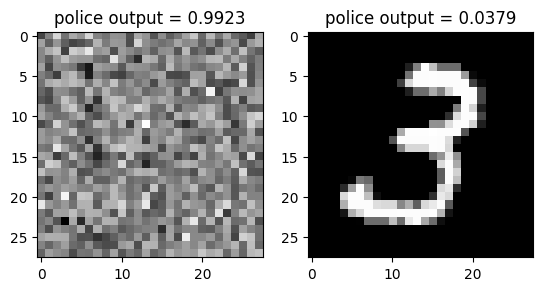

In [20]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(X_fake[[2]].squeeze(),cmap="gray")
ax[0].set_title(f"police output = {net_police(X_fake[[2]]).item():.4f}")
ax[1].imshow(X_real[[-1]].squeeze(),cmap="gray")
ax[1].set_title(f"police output = {net_police(X_real[[-1]]).item():.4f}")

## F. 더 똑똑해지는 페이커

`-` step1: noise $\to$ X_fake

In [21]:
X_fake = net_facker(torch.randn(6131,4))
# 여기서는 X_fake가 데이터가 아니고 네트워크 출력이므로 꼬리표를 제거하지 말아야함

`-` step2: 손실함수 - 페이커의 미덕 (잘 훈련된) 경찰이 가짜이미지를
진짜라고 판단하는 것. 즉 `yhat_fake` $\approx$ `y_real` 이어야 페이커의
실력이 우수하다고 볼 수 있음.

In [22]:
yhat_fake = net_police(X_fake)
loss_faker = bce(yhat_fake, y_real) 
# 가짜이미지를 보고 잘 훈련된 경찰도  
# 진짜 이미지라고 깜빡 속으면 
# 위조범의 실력이 좋다고 볼 수 있다는 의미

`-` step3~4:

In [23]:
class FlattenToImage(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        return X.reshape(-1,1,28,28)
net_facker = torch.nn.Sequential(
    torch.nn.Linear(4,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,784),
    torch.nn.Sigmoid(), # 출력을 0~1로 눌러주기 위한 레이어 // 저한테는 일종의 문화충격
    FlattenToImage()
)
bce = torch.nn.BCELoss()
optimizr_facker = torch.optim.Adam(net_facker.parameters())

In [24]:
for epoc in range(1):
    # step1 -- yhat을 얻음
    X_fake = net_facker(torch.randn(6131,4))
    # step2  -- loss를 계산
    yhat_fake = net_police(X_fake)
    loss_faker = bce(yhat_fake,y_real)
    # step3  -- 미분 
    loss_faker.backward()
    # step4 -- update 
    optimizr_facker.step()
    optimizr_facker.zero_grad()

`-` 위조범의 실력향상을 감상해보자.

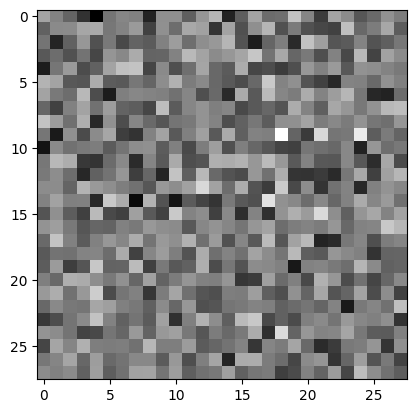

In [25]:
plt.imshow(X_fake[[0]].squeeze().data,cmap="gray")

## G. 경쟁학습

> 두 적대적인 네트워크를 경쟁시키자!

In [26]:
torch.manual_seed(43052)
net_police = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784,30),
    torch.nn.ReLU(),
    torch.nn.Linear(30,1),
    torch.nn.Sigmoid()
)
class FlattenToImage(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        return X.reshape(-1,1,28,28)
net_facker = torch.nn.Sequential(
    torch.nn.Linear(4,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,784),
    torch.nn.Sigmoid(), # 출력을 0~1로 눌러주기 위한 레이어 // 저한테는 일종의 문화충격
    FlattenToImage()
)
bce = torch.nn.BCELoss()
optimizr_police = torch.optim.Adam(net_police.parameters(),lr=0.001, betas=(0.5,0.999))
optimizr_facker = torch.optim.Adam(net_facker.parameters(),lr=0.0002, betas=(0.5,0.999))

In [27]:
for epoc in range(1000):
    #--- net_police 를 훈련 
    #step1
    X_fake = net_facker(torch.randn(6131,4)).data # 여기에서 X_fake는 data를 의미
    yhat_real = net_police(X_real)
    yhat_fake = net_police(X_fake)
    #step2
    loss_police = bce(yhat_real,y_real) + bce(yhat_fake,y_fake)
    #step3
    loss_police.backward()
    #step4
    optimizr_police.step()
    optimizr_police.zero_grad()
    #--- net_faker 를 훈련 
    #step1
    X_fake = net_facker(torch.randn(6131,4)) # 이때 X_fake는 net의 out을 의미 
    #step2
    yhat_fake = net_police(X_fake)
    loss_facker = bce(yhat_fake, y_real)
    #step3
    loss_facker.backward()
    #step4
    optimizr_facker.step()
    optimizr_facker.zero_grad()

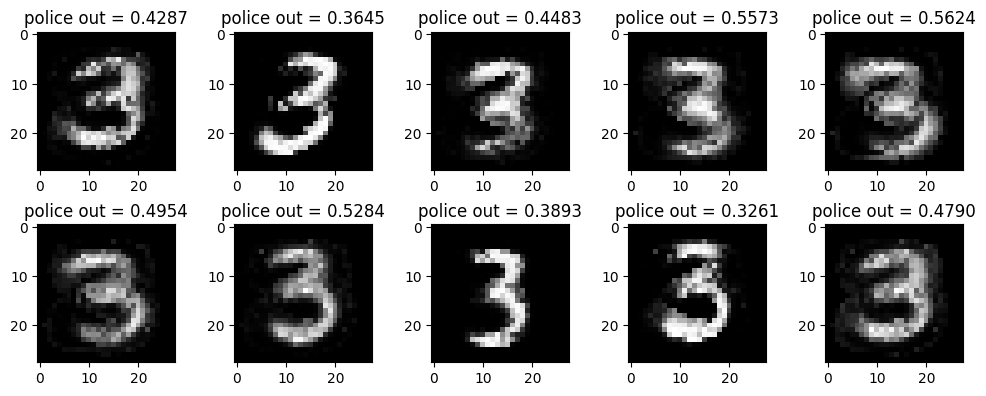

In [28]:
fig, ax  = plt.subplots(2,5,figsize=(10,4))
k=0
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(X_fake[[k]].data.squeeze(),cmap="gray")
        ax[i][j].set_title(f"police out = {net_police(X_fake[[k]]).item():.4f}")
        k= k+1
fig.tight_layout()

# 5. 초기 GAN의 한계점

`-` 두 네트워크의 균형이 매우 중요함 – 균형이 깨지는 순간 학습은 실패함

`-` 생성되는 이미지의 다양성이 부족한 경우가 발생함. (mode collapse)

Goodfellow, Ian, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David
Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio. 2014.
“Generative Adversarial Nets.” *Advances in Neural Information
Processing Systems* 27.